In [1]:
%matplotlib inline
import numpy_financial as npf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# How a Monthly Payment/Equated Monthly Installment is Calculated

In [2]:
Principal = float(input('Enter the principal amount:'))
Interest_rate = float(input('Enter interest rate as a percentage:'))/100
Years = int(input('Enter the loan term in years:'))
Freq = int(input('Enter the payment frequency per year:'))
start = datetime.datetime.strptime(input('Enter start date in the format yy/mm/dd:'), '%y/%m/%d')

Enter the principal amount:200000
Enter interest rate as a percentage:5
Enter the loan term in years:30
Enter the payment frequency per year:12
Enter start date in the format yy/mm/dd:18/03/01


## The mortgage principal amount will be the balance after deducting the down payment.

Using pmt function from numpy, we can find the monthly payment amount.

In [3]:
pmt = npf.pmt(Interest_rate/Freq, Years*Freq, Principal)
pmt

-1073.6432460242797

So the monthly payment is \\$954.83, but how much of that is interest and how much principal? That depends on the period. Although the monthly payment stays the same, as time goes by, the interest paid per period decreases as the amount paying toward principal increases.

# How Interest Rates Affect Monthly Payments

### To calculate the first month of interest and principal:

In [4]:
# Period to calculate
per = 1

# Calculate the interest
ipmt = npf.ipmt(Interest_rate/Freq, per, Years*Freq, Principal)

# Calculate the principal
ppmt = npf.ppmt(Interest_rate/Freq, per, Years*Freq, Principal)

print(ipmt, ppmt)

-833.3333333333334 -240.30991269094636


Of the \\$954.83, \\$666.67 is interest and only $288.16 is principal.

### Let's compare that with the last period.

In [5]:
perfinal = 360
ipmt = npf.ipmt(Interest_rate/Freq, perfinal, Years*Freq, Principal)
ppmt = npf.ppmt(Interest_rate/Freq, perfinal, Years*Freq, Principal)
print(ipmt, ppmt)

-4.454951228316349 -1069.1882947959634


### The difference is huge!

At the beginning of the loan, interest costs are at their highest. Not much of the payment goes to principal repayment; most of it is interest. As time goes on, the principal decreases and in turn the interest on the principal also. That means more and more of each payment goes towards repaying the princiapal and you pay less interest each time.

## To help illustrate, let's make an amortization table using pandas DataFrame.

In [6]:
#DateTimeIndex for the entire mortgage period
rng = pd.date_range(start, periods=Years*Freq, freq='MS', name='Payment Date')
rng

DatetimeIndex(['2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01',
               ...
               '2047-05-01', '2047-06-01', '2047-07-01', '2047-08-01',
               '2047-09-01', '2047-10-01', '2047-11-01', '2047-12-01',
               '2048-01-01', '2048-02-01'],
              dtype='datetime64[ns]', name='Payment Date', length=360, freq='MS')

In [7]:
df = pd.DataFrame(index=rng,columns=['Monthly Payment', 'Principal','Interest','Cumulative Principal','New Balance'], dtype='float')
df.reset_index(inplace=True)
df.index += 1
df.index.name = "Period"
df["Monthly Payment"] = npf.pmt(Interest_rate/Freq, Years*Freq, Principal)
df["Interest"] = npf.ipmt(Interest_rate/Freq, df.index, Years*Freq, Principal)
df["Principal"] = npf.ppmt(Interest_rate/Freq, df.index, Years*Freq, Principal)
df['Cumulative Principal'] = df['Principal'].cumsum()
df['Cumulative Principal'] = df['Cumulative Principal'].clip(lower=-Principal)
df['New Balance'] = Principal + df['Cumulative Principal']
df = df.round(2)
df

,Payment Date,Monthly Payment,Principal,Interest,Cumulative Principal,New Balance
Period,,,,,,
1,2018-03-01,-1073.64,-240.31,-833.33,-240.31,199759.69
2,2018-04-01,-1073.64,-241.31,-832.33,-481.62,199518.38
3,2018-05-01,-1073.64,-242.32,-831.33,-723.94,199276.06
4,2018-06-01,-1073.64,-243.33,-830.32,-967.26,199032.74
5,2018-07-01,-1073.64,-244.34,-829.30,-1211.60,198788.40
...,...,...,...,...,...,...
356,2047-10-01,-1073.64,-1051.55,-22.09,-195749.79,4250.21
357,2047-11-01,-1073.64,-1055.93,-17.71,-196805.73,3194.27
358,2047-12-01,-1073.64,-1060.33,-13.31,-197866.06,2133.94


In [8]:
print('Total interest paid over the whole life cycle is: ${0}.'.format(-df['Interest'].sum()))

Total interest paid over the whole life cycle is: $186511.64.


## To compare different amortization schedules, we can use the following function.

In [9]:
def amortization_table(interest_rate, years, frequency, principal, start_date=datetime.date.today()):
    rng = pd.date_range(start_date, periods=years*frequency, freq='MS', name='Payment Date')
    table = pd.DataFrame(index=rng,columns=['Monthly Payment', 'Principal','Interest','Cumulative Principal','New Balance'], dtype='float')
    table.reset_index(inplace=True)
    table.index += 1
    table.index.name = "Period"
    table["Monthly Payment"] = npf.pmt(interest_rate/frequency, years*frequency, principal)
    table["Interest"] = npf.ipmt(interest_rate/frequency, table.index, years*frequency, principal)
    table["Principal"] = npf.ppmt(interest_rate/frequency, table.index, years*frequency, principal)
    table['Cumulative Principal'] = table['Principal'].cumsum()
    table['Cumulative Principal'] = table['Cumulative Principal'].clip(lower=-principal)
    table['New Balance'] = principal + table['Cumulative Principal']
    table = table.round(2)
    print('Total interest paid over the whole life cycle is ${0} with a monthly payment of ${1}.'.format(np.round(-table['Interest'].sum(),2), -table.loc[1, "Monthly Payment"]))
    return table

In [10]:
schedule1 = amortization_table(0.04, 30, 12, 100000)
schedule2 = amortization_table(0.04, 15, 12, 100000)

Total interest paid over the whole life cycle is $71869.44 with a monthly payment of $477.42.
Total interest paid over the whole life cycle is $33143.85 with a monthly payment of $739.69.


In [11]:
schedule1

,Payment Date,Monthly Payment,Principal,Interest,Cumulative Principal,New Balance
Period,,,,,,
1,2020-05-01,-477.42,-144.08,-333.33,-144.08,99855.92
2,2020-06-01,-477.42,-144.56,-332.85,-288.64,99711.36
3,2020-07-01,-477.42,-145.04,-332.37,-433.69,99566.31
4,2020-08-01,-477.42,-145.53,-331.89,-579.22,99420.78
5,2020-09-01,-477.42,-146.01,-331.40,-725.23,99274.77
...,...,...,...,...,...,...
356,2049-12-01,-477.42,-469.54,-7.88,-98106.15,1893.85
357,2050-01-01,-477.42,-471.10,-6.31,-98577.25,1422.75
358,2050-02-01,-477.42,-472.67,-4.74,-99049.92,950.08


In [12]:
schedule2

,Payment Date,Monthly Payment,Principal,Interest,Cumulative Principal,New Balance
Period,,,,,,
1,2020-05-01,-739.69,-406.35,-333.33,-406.35,99593.65
2,2020-06-01,-739.69,-407.71,-331.98,-814.06,99185.94
3,2020-07-01,-739.69,-409.07,-330.62,-1223.13,98776.87
4,2020-08-01,-739.69,-410.43,-329.26,-1633.56,98366.44
5,2020-09-01,-739.69,-411.80,-327.89,-2045.36,97954.64
...,...,...,...,...,...,...
176,2034-12-01,-739.69,-727.48,-12.21,-97065.74,2934.26
177,2035-01-01,-739.69,-729.91,-9.78,-97795.65,2204.35
178,2035-02-01,-739.69,-732.34,-7.35,-98527.99,1472.01


# Visualizations

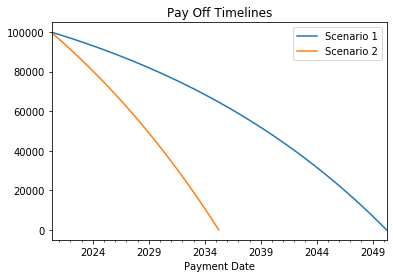

In [13]:
fig, ax = plt.subplots(1, 1)
schedule1.plot(x='Payment Date', y='New Balance', label="Scenario 1", ax=ax)
schedule2.plot(x='Payment Date', y='New Balance', label="Scenario 2", ax=ax)
plt.title("Pay Off Timelines");

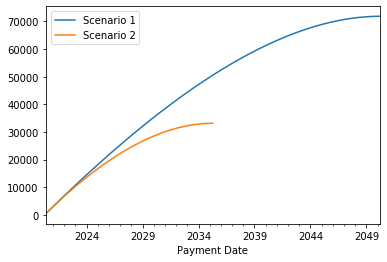

In [14]:
schedule1["Cumulative Interest"] = schedule1["Interest"].abs().cumsum()
schedule2["Cumulative Interest"] = schedule2["Interest"].abs().cumsum()
fig, ax = plt.subplots(1, 1)

schedule1.plot(x='Payment Date', y='Cumulative Interest', label="Scenario 1", ax=ax)
schedule2.plot(x='Payment Date', y='Cumulative Interest', label="Scenario 2", ax=ax)

ax.legend(loc="best");